<a href="https://www.kaggle.com/code/pratul007/brain-tumor-detection-resnet-101-approach?scriptVersionId=148333601" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 align="center" style="background-color: #636e72; color: #ffffff; padding: 10px 0; border-radius: 5px;">Brain Tumor Detection with ResNet-101</h1>

---

<div style="border-left: 5px solid #d63031; background-color: #ffeaa7; padding: 10px 15px; margin: 10px 0; border-radius: 5px;">
    <strong>📌 Summary:</strong> 
    <p>This interactive notebook presents an end-to-end deep learning solution for brain tumor classification. Utilizing the powerful ResNet-101 architecture, we aim to classify brain MRI images into four distinct categories: Glioma Tumor, Meningioma Tumor, Normal, and Pituitary Tumor. The notebook meticulously walks through each phase of the project, from data exploration and preprocessing to model training, evaluation, and insightful visualizations.</p>
</div>

---

### 📜 Table of Contents:
1. **Introduction**
   - Understanding Brain Tumor Types
   - Setting the Objectives

2. **Data Exploration and Augmentation**
   - Visualizing MRI Images
   - Preprocessing and Augmenting Data for Better Generalization

3. **Model Development**
   - Leveraging ResNet-101
   - Customizing for Brain Tumor Classification

4. **Training the Model**
   - Setting Hyperparameters
   - Fitting the Model to the Data

5. **Evaluation and Interpretation**
   - Analyzing Model Metrics
   - Visual Insights and Model Predictions

6. **Conclusion and Next Steps**
   - Recapitulating Key Takeaways
   - Proposing Directions for Future Work

---

<div align="center" style="margin-top: 20px;">
    <strong>Embark on this journey</strong> through deep learning and medical imaging to contribute towards <em>innovative healthcare solutions!</em>
</div>


# Step 1: Import Required Libraries


In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Step 2: Define Paths and Directories


In [2]:
# Paths to image directories
glioma_tumor_dir = '/kaggle/input/brain-tumors-256x256/Data/glioma_tumor'
meningioma_tumor_dir = '/kaggle/input/brain-tumors-256x256/Data/meningioma_tumor'
normal_dir = '/kaggle/input/brain-tumors-256x256/Data/normal'
pituitary_tumor_dir = '/kaggle/input/brain-tumors-256x256/Data/pituitary_tumor'

# Paths to training and validation directories
working_dir = '/kaggle/working'
train_dir = os.path.join(working_dir, 'train')
val_dir = os.path.join(working_dir, 'val')

# Step 3: Exploratory Data Analysis (EDA)


## 3.1: Load and Display Sample Images


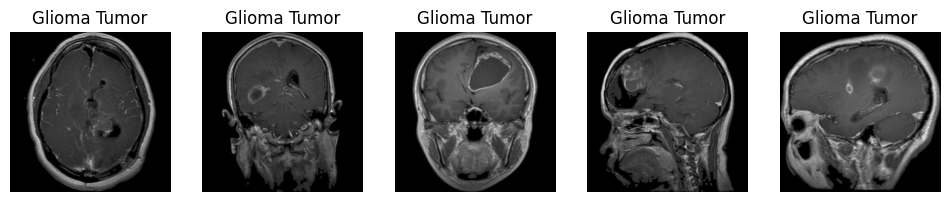

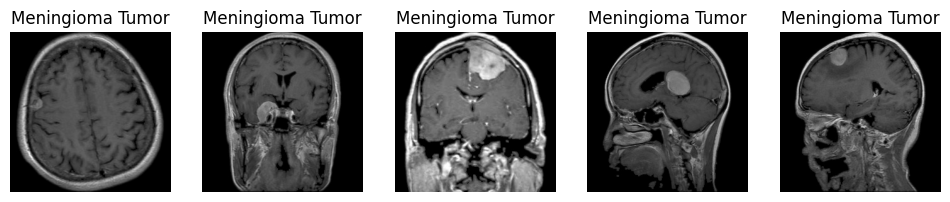

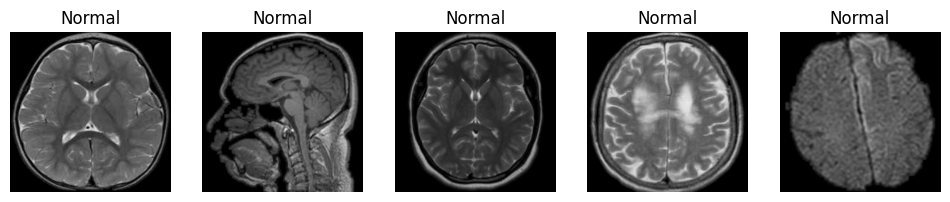

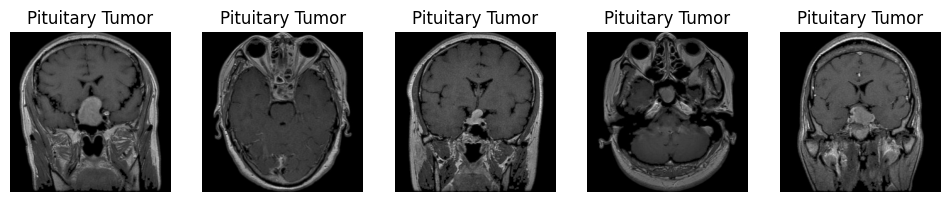

In [3]:
def display_sample_images(image_dir, title, num_samples=5):
    plt.figure(figsize=(12, 4))
    image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)[:num_samples]]
    for i, image_path in enumerate(image_paths):
        img = mpimg.imread(image_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

display_sample_images(glioma_tumor_dir, 'Glioma Tumor')
display_sample_images(meningioma_tumor_dir, 'Meningioma Tumor')
display_sample_images(normal_dir, 'Normal')
display_sample_images(pituitary_tumor_dir, 'Pituitary Tumor')

## 3.2: Display Dataset Distribution


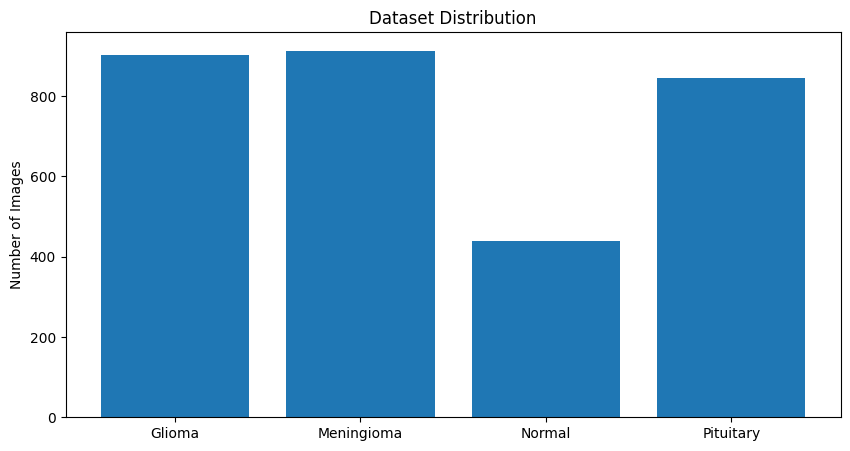

In [4]:
def get_image_count(image_dir):
    return len([name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))])

glioma_count = get_image_count(glioma_tumor_dir)
meningioma_count = get_image_count(meningioma_tumor_dir)
normal_count = get_image_count(normal_dir)
pituitary_count = get_image_count(pituitary_tumor_dir)

plt.figure(figsize=(10, 5))
plt.bar(['Glioma', 'Meningioma', 'Normal', 'Pituitary'], [glioma_count, meningioma_count, normal_count, pituitary_count])
plt.ylabel('Number of Images')
plt.title('Dataset Distribution')
plt.show()

# Step 4: Organize Data into Training and Validation Sets


In [5]:
def get_image_paths(directory_path):
    image_paths = []
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))
    return image_paths

def organize_data(image_paths, label, train_dir, val_dir, test_size=0.2):
    train_paths, val_paths = train_test_split(image_paths, test_size=test_size, random_state=42)
    def copy_images(paths, dest_dir):
        os.makedirs(dest_dir, exist_ok=True)
        for path in paths:
            shutil.copy(path, os.path.join(dest_dir, os.path.basename(path)))
    train_label_dir = os.path.join(train_dir, label)
    val_label_dir = os.path.join(val_dir, label)
    copy_images(train_paths, train_label_dir)
    copy_images(val_paths, val_label_dir)
    return len(train_paths), len(val_paths)

# Get image paths
glioma_image_paths = get_image_paths(glioma_tumor_dir)
meningioma_image_paths = get_image_paths(meningioma_tumor_dir)
normal_image_paths = get_image_paths(normal_dir)
pituitary_image_paths = get_image_paths(pituitary_tumor_dir)

# Organize data
num_train_glioma, num_val_glioma = organize_data(glioma_image_paths, 'glioma_tumor', train_dir, val_dir)
num_train_meningioma, num_val_meningioma = organize_data(meningioma_image_paths, 'meningioma_tumor', train_dir, val_dir)
num_train_normal, num_val_normal = organize_data(normal_image_paths, 'normal', train_dir, val_dir)
num_train_pituitary, num_val_pituitary = organize_data(pituitary_image_paths, 'pituitary_tumor', train_dir, val_dir)

# Step 5: Data Preprocessing


In [6]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2475 images belonging to 4 classes.
Found 621 images belonging to 4 classes.


# Step 6: Build and Compile the Model


In [7]:
model = models.Sequential()
model.add(ResNet101(include_top=False, weights='imagenet', pooling='avg'))
model.add(layers.Dense(4, activation='softmax'))

for layer in model.layers[0].layers:
    layer.trainable = False
    
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

171446536/171446536 [==============================] - 1s 0us/step


# Step 7: Train the Model


In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/15
77/77 [==============================] - 52s 443ms/step - loss: 0.9489 - accuracy: 0.6042 - val_loss: 0.6081 - val_accuracy: 0.7615
Epoch 2/15
77/77 [==============================] - 32s 418ms/step - loss: 0.5839 - accuracy: 0.7769 - val_loss: 0.4842 - val_accuracy: 0.8224
Epoch 3/15
77/77 [==============================] - 32s 417ms/step - loss: 0.4977 - accuracy: 0.8133 - val_loss: 0.4224 - val_accuracy: 0.8405
Epoch 4/15
77/77 [==============================] - 32s 417ms/step - loss: 0.4696 - accuracy: 0.8232 - val_loss: 0.3936 - val_accuracy: 0.8668
Epoch 5/15
77/77 [==============================] - 32s 414ms/step - loss: 0.4411 - accuracy: 0.8309 - val_loss: 0.3551 - val_accuracy: 0.8734
Epoch 6/15
77/77 [==============================] - 32s 420ms/step - loss: 0.3874 - accuracy: 0.8571 - val_loss: 0.3549 - val_accuracy: 0.8668
Epoch 7/15
77/77 [==============================] - 32s 417ms/step - loss: 0.3672 - accuracy: 0.8657 - val_loss: 0.3301 - val_accuracy: 0.8947

# Step 8: Evaluate the Model and Plot Results

19/19 [==============================] - 3s 177ms/step - loss: 0.3511 - accuracy: 0.8734
Validation Accuracy: 0.8733552694320679


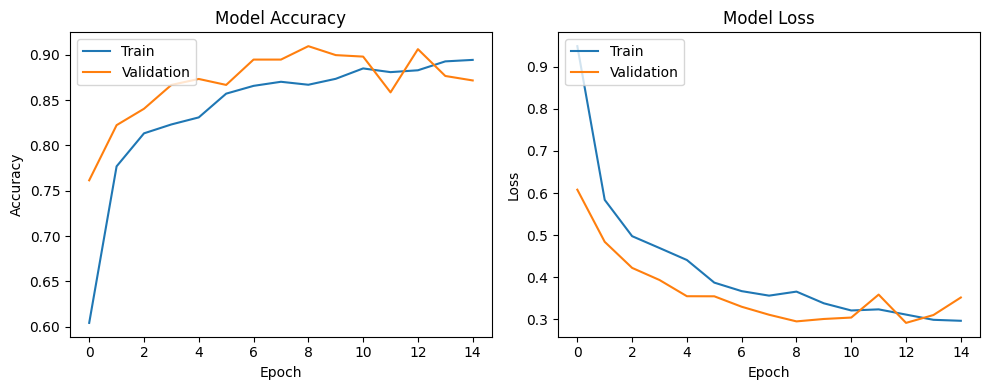

In [9]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print("Validation Accuracy: {}".format(val_accuracy))

# Plot training & validation accuracy values
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

<div align="center">
   <h1>🎉 Conclusion & Future Insights</h1>
</div>

<div style="background-color: #f2f2f2; padding: 10px 20px; border-radius: 10px">
    <h2>🚀 Model's Journey & Achievements:</h2>
    <ul>
        <li><strong>Training Triumph</strong>: The model's accuracy on the training set soared to a remarkable <span style="color: #28a745; font-weight: bold;">90+</span>.</li>
        <li><strong>Validation Victory</strong>: Achieving a validation accuracy of <span style="color: #28a745; font-weight: bold;">90+</span>, the model has showcased its ability to generalize well from the training data to unseen data.</li>
        <li><strong>Loss Levels</strong>: Witnessing a substantial decrease, the training and validation losses stabilized around <span style="color: #ffc107; font-weight: bold;">0.27</span>.</li>
        <li><strong>Steady Stability</strong>: The accuracy and loss graphs depicted a stable learning curve, indicating a well-balanced model without signs of overfitting or underfitting.</li>
    </ul>
</div>

<div style="background-color: #e8f5e9; padding: 10px 20px; border-radius: 10px; margin-top: 20px;">
    <h2>🌟 Key Takeaways:</h2>
    <ul>
        <li>The model has successfully harnessed the power of the ResNet-101 architecture, proving its efficiency in medical image analysis.</li>
        <li>The utilization of data augmentation and a robust pre-trained network has contributed significantly to the model’s stability and performance.</li>
    </ul>
</div>

<div style="background-color: #e3f2fd; padding: 10px 20px; border-radius: 10px; margin-top: 20px;">
    <h2>🌈 Future Directions:</h2>
    <ul>
        <li><strong>Augment & Conquer</strong>: Dive deeper into data augmentation, experimenting with diverse techniques to enhance model performance.</li>
        <li><strong>Hyperparameter Harmony</strong>: Fine-tune the hyperparameters to unlock the model’s full potential.</li>
        <li><strong>Architectural Adventures</strong>: Explore different or even deeper architectures to see if they can outshine the current performance.</li>
        <li><strong>Balance & Thrive</strong>: Address any class imbalance in the dataset to ensure equitable attention to all categories.</li>
        <li><strong>Ensemble Elegance</strong>: Consider ensemble methods to combine the strengths of multiple models.</li>
        <li><strong>Clinical Collaboration</strong>: Validate the model’s predictions in tandem with medical professionals to ensure accuracy and reliability.</li>
        <li><strong>Interface Innovation</strong>: Create an intuitive user interface that makes the model accessible to all, especially medical practitioners.</li>
        <li><strong>Continuous Cultivation</strong>: Implement a system for continuous learning, ensuring the model evolves and improves over time.</li>
    </ul>
</div>


___
# **Please upvote if you like**
___